In [61]:
import os
import numpy as np
import torch
import open_clip

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [62]:
model, _, preprocess = open_clip.create_model_and_transforms('Align-fMRI-Encoder-small', pretrained='roberta-base')

/home/rickc/Projects/CV/open_clip/src/open_clip/factory.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_locat

In [63]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 210,684,417
Context length: 514
Vocab size: 50265


In [64]:
tokenizer = open_clip.get_tokenizer("Align-fMRI-Encoder-small")

/root/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [65]:
# prepare input
text = "Hello World!"
encoded_input = tokenizer(text)

In [66]:
encoded_input

tensor([[    0, 31414,   623,   328,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1]])

## Building features

In [67]:
fMRI_dir = '/home/rickc/Projects/fMRI/fMRIAlignment/data/nsd/betas_subj01_batch09.npy'

fMRI_dir_val = '/home/rickc/Projects/fMRI/fMRIAlignment/data/nsd/betas_subj01_batch10.npy'

In [68]:
fMRI_data_all = np.load(fMRI_dir)
fMRI_data_all_val = np.load(fMRI_dir_val)
fMRI_data_all.shape

(3000, 13888)

In [69]:
fMRI_data = fMRI_data_all[:10,]
fMRI_data_val = fMRI_data_all_val[:10,]
fMRI_data.shape

(10, 13888)

In [70]:
fMRI_data = fMRI_data.reshape(fMRI_data.shape[0], 1, fMRI_data.shape[1])

In [71]:
fMRI_data_val = fMRI_data_val.reshape(fMRI_data_val.shape[0], 1, fMRI_data_val.shape[1])

In [72]:
fMRI_data_val.shape

(10, 1, 13888)

In [73]:
fMRI_input = torch.tensor(np.stack(fMRI_data[:10,]))
fMRI_input = fMRI_input.float()
fMRI_input.size()

torch.Size([10, 1, 13888])

In [74]:
fMRI_input_val = torch.tensor(np.stack(fMRI_data_val[:10,]))
fMRI_input_val = fMRI_input_val.float()
fMRI_input_val.size()

torch.Size([10, 1, 13888])

In [75]:
caption_dir = '/home/rickc/Projects/fMRI/fMRI2TextAligner/notebooks/train.csv'


caption_val_dir = '/home/rickc/Projects/fMRI/fMRI2TextAligner/notebooks/val.csv'

In [76]:
import pandas as pd

captions = []
captions_val = []

df = pd.read_csv(caption_dir)
df_val = pd.read_csv(caption_val_dir)


captions_df = df['title'].iloc[24000:24010]


captions_df_val = df_val['title'].iloc[0:10]


for i in captions_df:
    captions.append(i)

for i in captions_df_val:
    captions_val.append(i)

In [77]:
captions_val

['A man in a black tank top sits at a large wooden desk while looking at an open keyboard.',
 'A man in a full wet suit surfs a wave.',
 'Two men riding their horses on a grassy hill with sheep in the background.',
 'A red stop sign on the corner of a city street.',
 'A group of boats parked in a marina in a large body of water.',
 'Three feminine bags are on display in a store window.',
 'A toy fish lays on a pillow on a bed that is made and has white sheets and a light colored blanket.',
 'A cell phone sits on a desk next to a green box.',
 'A plate of pasta and pepperoni pizza and a slice with vegetables.',
 'A plate of food with some eggs, bacon, ham, and bread on it.']

In [78]:
text_tokens = tokenizer(captions)
text_tokens_val = tokenizer(captions_val)
text_tokens.size()

torch.Size([10, 77])

In [79]:
with torch.no_grad():
    fMRI_features = model.encode_image(fMRI_input).float()
    text_features = model.encode_text(text_tokens).float()
    fMRI_features_val = model.encode_image(fMRI_input_val).float()
    text_features_val = model.encode_text(text_tokens_val).float()

In [80]:
fMRI_features.size()

torch.Size([10, 512])

In [81]:
text_features.size()

torch.Size([10, 512])

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [82]:
image_norm = fMRI_features.norm(dim=-1, keepdim=True)
text_norm = text_features.norm(dim=-1, keepdim=True)

In [83]:
image_norm_val = fMRI_features_val.norm(dim=-1, keepdim=True)
text_norm_val = text_features_val.norm(dim=-1, keepdim=True)

In [84]:
image_norm_val

tensor([[30.7770],
        [36.0553],
        [34.2096],
        [32.1528],
        [32.3444],
        [31.2252],
        [31.7416],
        [34.7315],
        [34.1303],
        [31.0842]])

In [85]:
text_norm

tensor([[1.6914],
        [1.8252],
        [2.3358],
        [2.0126],
        [2.1887],
        [2.0188],
        [2.1316],
        [2.2988],
        [2.0947],
        [1.7369]])

In [86]:
fMRI_features /= image_norm
text_features /= text_norm
similarity = text_features.cpu().numpy() @ fMRI_features.cpu().numpy().T

In [87]:
fMRI_features_val /= image_norm_val
text_features_val /= text_norm_val
similarity_val = text_features_val.cpu().numpy() @ fMRI_features_val.cpu().numpy().T

In [88]:
fMRI_features_val

tensor([[ 0.0645, -0.0462, -0.0053,  ...,  0.0859,  0.0274, -0.0422],
        [ 0.0379,  0.0358, -0.0612,  ..., -0.0209, -0.0512,  0.0315],
        [ 0.0345,  0.0056, -0.0128,  ..., -0.0275, -0.0423, -0.0101],
        ...,
        [ 0.0112, -0.0170,  0.0610,  ..., -0.0192,  0.0413, -0.0283],
        [ 0.0428,  0.0381, -0.0288,  ...,  0.0365, -0.0100, -0.0045],
        [ 0.0570,  0.0126,  0.0038,  ...,  0.0756,  0.0370, -0.0576]])

In [89]:
text_features

tensor([[ 0.0406,  0.0354,  0.0096,  ..., -0.0089,  0.0149, -0.0477],
        [ 0.0293, -0.1161,  0.0495,  ..., -0.0036, -0.0320,  0.0178],
        [-0.0241, -0.0150,  0.0241,  ...,  0.1304, -0.0070,  0.0532],
        ...,
        [ 0.0314, -0.0015,  0.0646,  ..., -0.0303,  0.0300, -0.0144],
        [ 0.0101,  0.0149,  0.0213,  ..., -0.0120,  0.1047, -0.0391],
        [-0.0024, -0.0223, -0.0718,  ..., -0.0406, -0.0495, -0.0792]])

In [90]:
similarity.shape

(10, 10)

In [91]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Text(0.5, 1.0, 'Cosine similarity between text and image features')

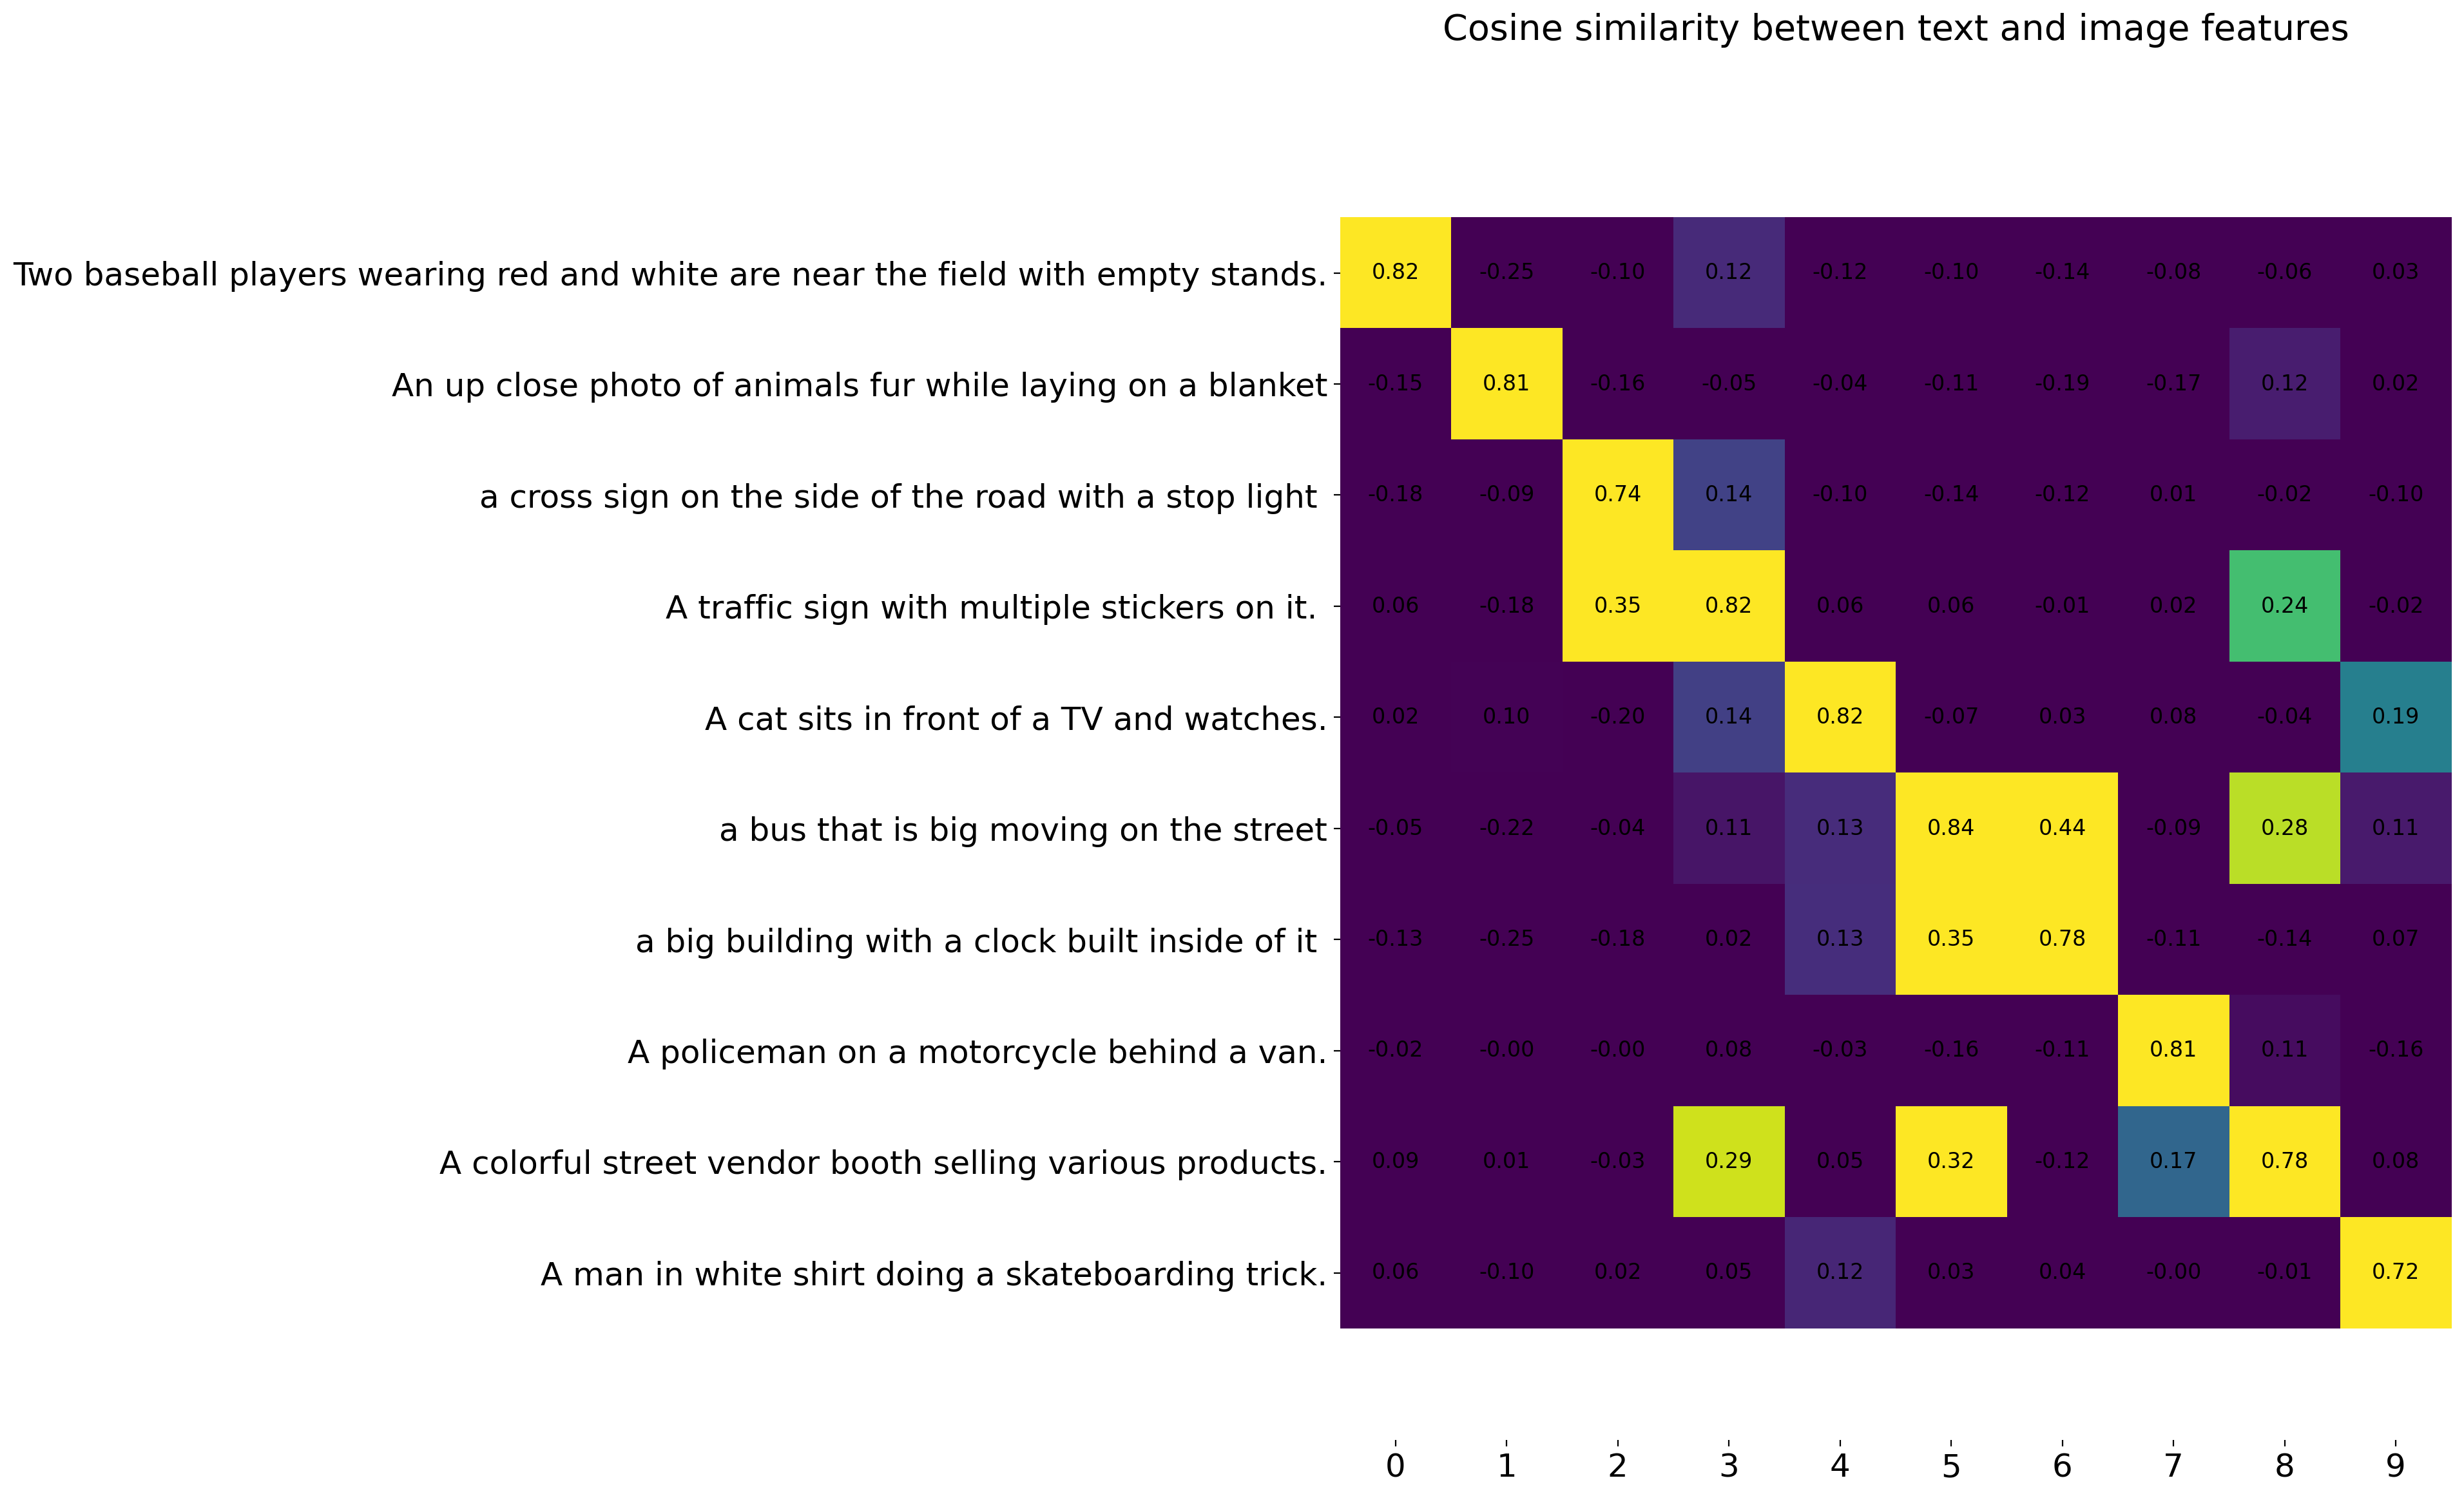

In [92]:

count = 10

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), captions, fontsize=18)
plt.xticks(range(count), range(count),fontsize=18)
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

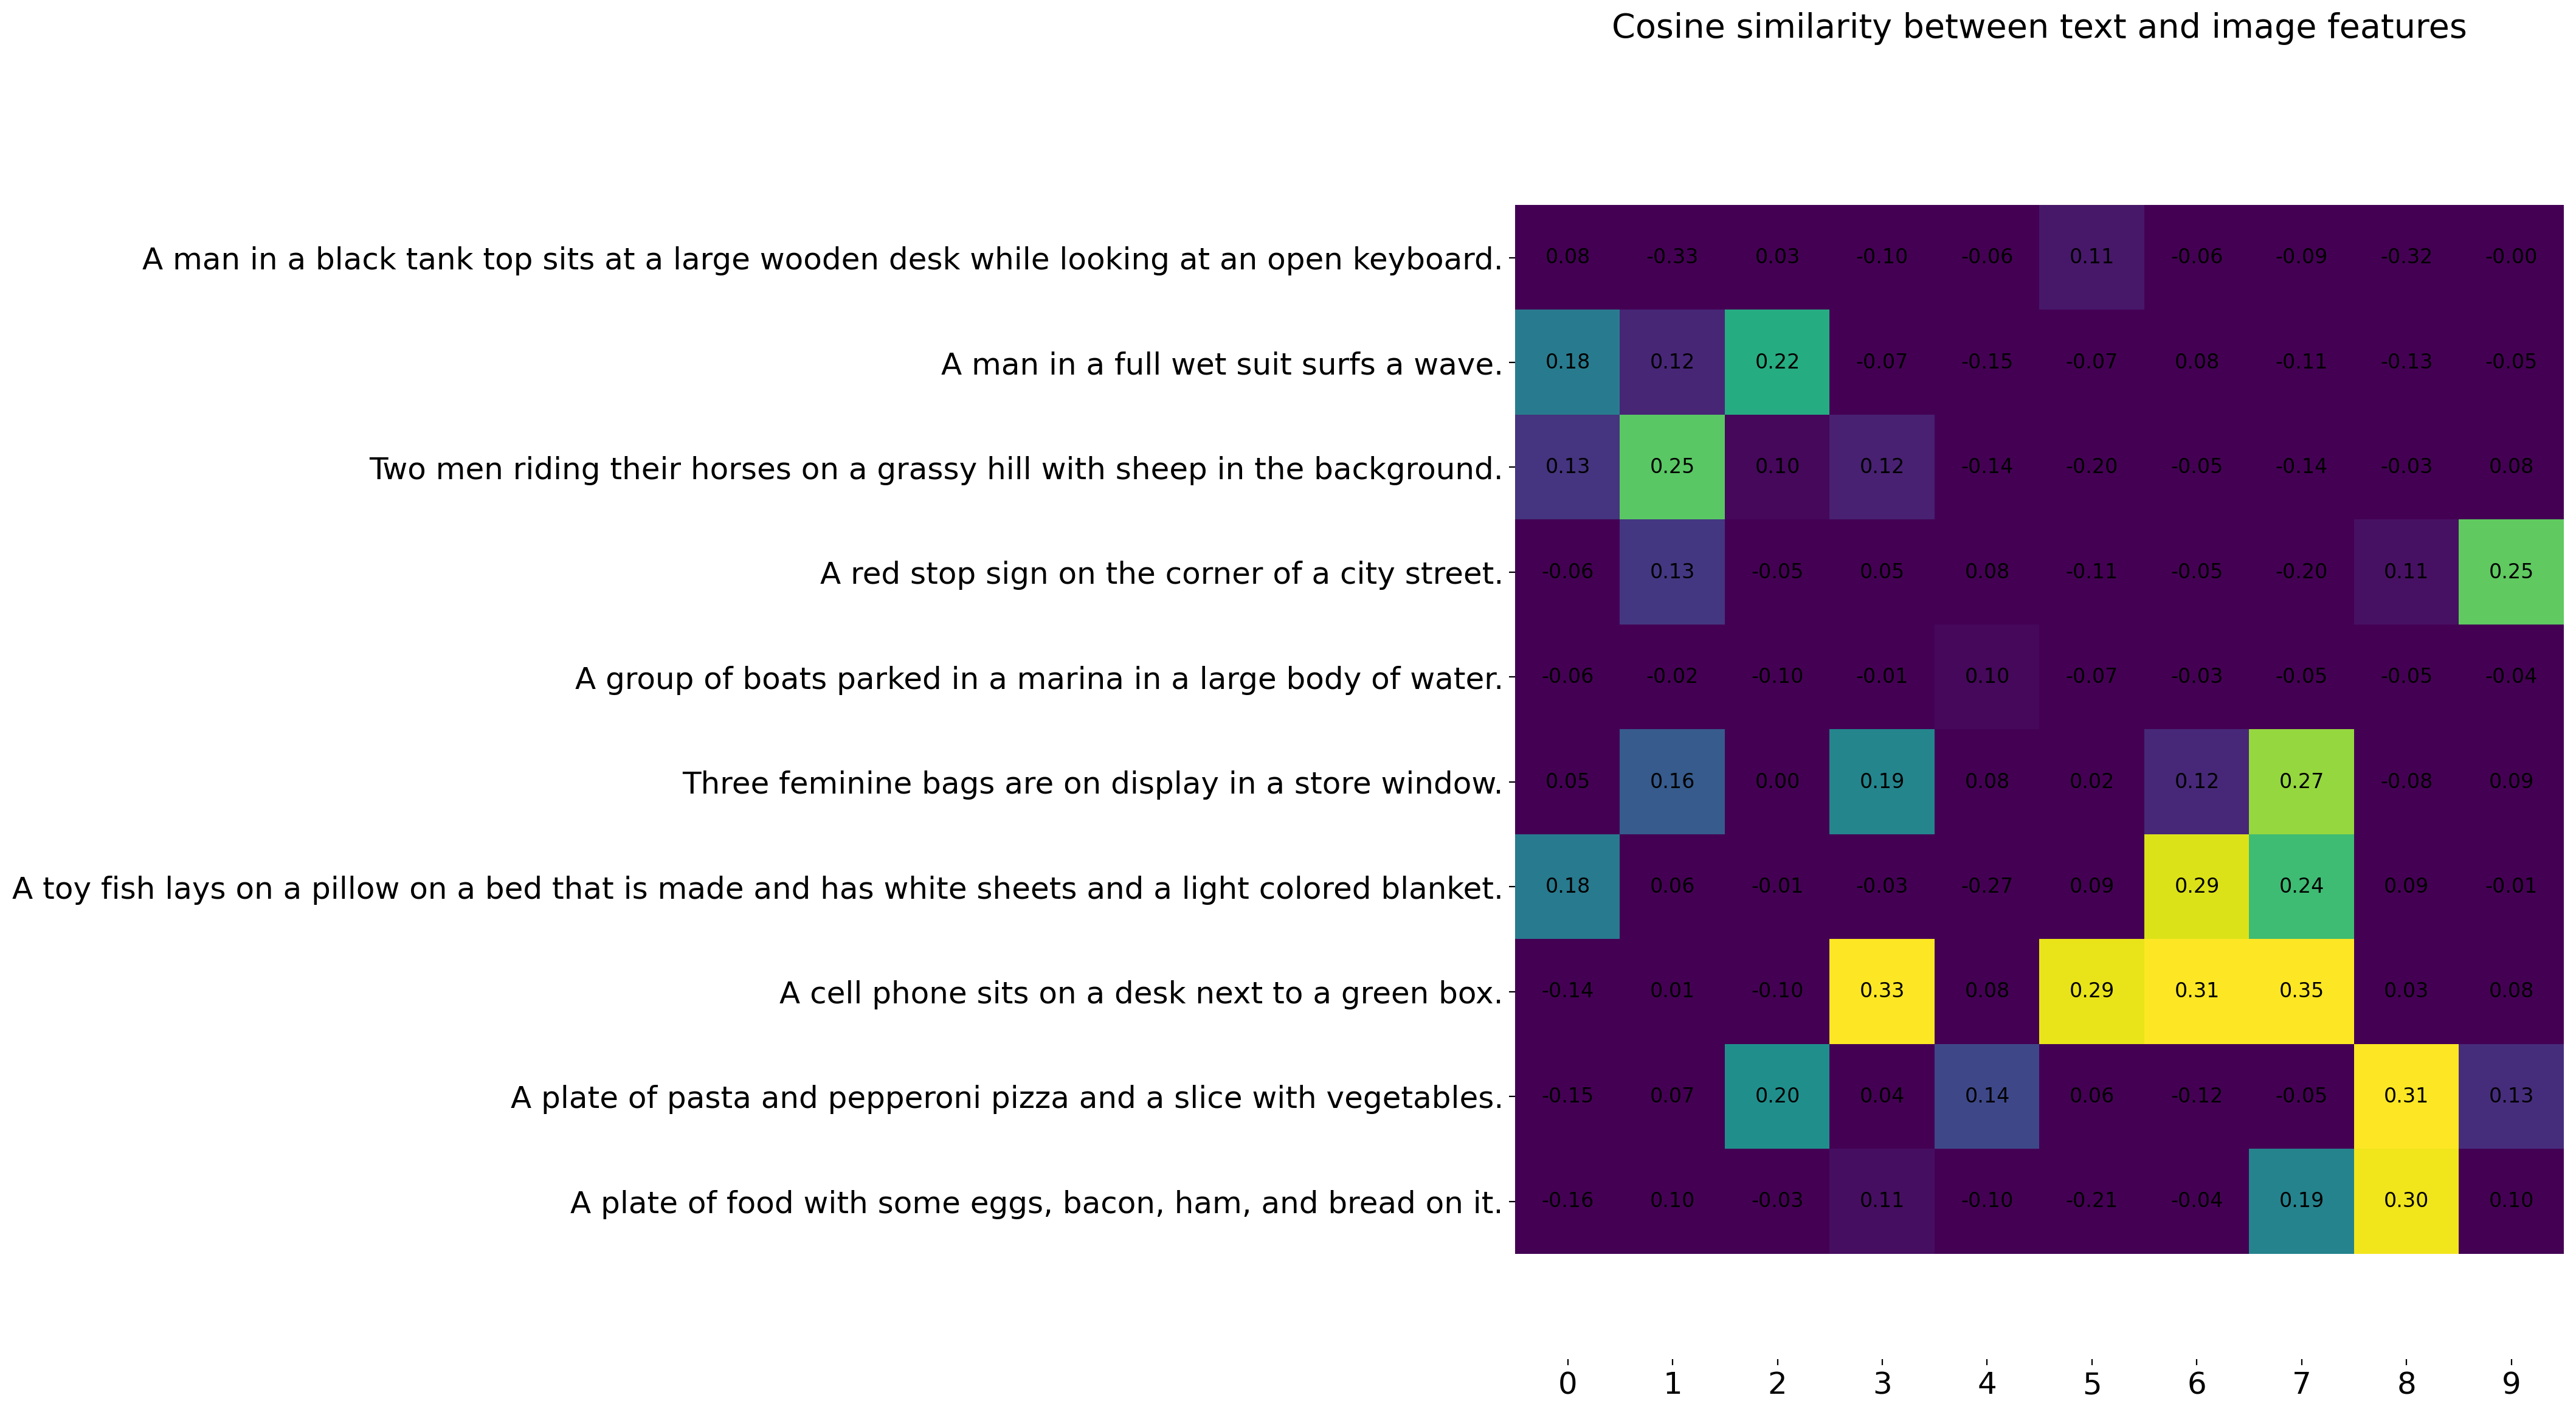

In [93]:

count = 10

plt.figure(figsize=(20, 14))
plt.imshow(similarity_val, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), captions_val, fontsize=18)
plt.xticks(range(count), range(count),fontsize=18)
for x in range(similarity_val.shape[1]):
    for y in range(similarity_val.shape[0]):
        plt.text(x, y, f"{similarity_val[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)